<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a movie review sentiment model with RISE
This notebook demonstrates the use of DIANNA with the RISE method on the [Stanford Sentiment Treebank dataset](https://nlp.stanford.edu/sentiment/index.html) which contains one-sentence movie reviews. See also [their paper](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf). A pre-trained neural network classifier is used, which identifies whether a movie review is positive or negative.

[RISE](http://bmvc2018.org/contents/papers/1064.pdf) is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates each word's relevance to the model's decision empirically by probing the model with randomly masked versions of the input image and obtaining the corresponding outputs.  

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the RISE parameters

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0 -  Imports and paths

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import spacy
from scipy.special import expit as sigmoid
import pandas as pd

import dianna
from dianna import visualization
from dianna import utils
from dianna.utils.tokenizers import SpacyTokenizer
from dianna.utils.downloader import download

In [3]:
model_path = download('movie_review_model.onnx', 'model')
word_vector_path = download('movie_reviews_word_vectors.txt', 'data')
labels = ("negative", "positive")

#### 1 - Loading the model

The classifier is stored in ONNX format. It accepts numerical tokens as input, and outputs a score between 0 and 1, where 0 means the review is negative and 1 that it is positive.  
Here we define a class to run the model, which accepts a sentence (i.e. string) as input instead and returns two classes: negative and positive.

In [4]:
# ensure the tokenizer for english is available
spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
class MovieReviewsModelRunner:
    def __init__(self, model, word_vectors, max_filter_size):
        self.run_model = utils.get_function(model)
        self.max_filter_size = max_filter_size
        self.keys = list(pd.read_csv(word_vector_path, header=None, delimiter=' ')[0])
        self.tokenizer = SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        output = []
        for sentence in sentences:
            # tokenize and pad to minimum length
            tokens = self.tokenizer.tokenize(sentence.lower())
            if len(tokens) < self.max_filter_size:
                tokens += ['<pad>'] * (self.max_filter_size - len(tokens))
            
            # numericalize the tokens
            tokens_numerical = [self.keys.index(token) if token in self.keys else self.keys.index('<unk>')
                                for token in tokens]

            # run the model, applying a sigmoid because the model outputs logits, remove any remaining batch axis
            pred = float(sigmoid(self.run_model([tokens_numerical])))
            output.append(pred)

        # output two classes
        positivity = np.array(output)
        negativity = 1 - positivity
        return np.transpose([negativity, positivity])
            

In [6]:
# define model runner. max_filter_size is a property of the model
model_runner = MovieReviewsModelRunner(model_path, word_vector_path, max_filter_size=5)

#### 2 - Applying RISE with DIANNA
The simplest way to run DIANNA on text data is with `dianna.explain_text`. The arguments are:
* The function that runs the model (a path to a model in ONNX format is also accepted)
* The text we want to explain
* The name of the explainable-AI method we want to use, here RISE
* The numerical indices of the classes we want an explanation for

`dianna.explain_text` returns a list of tuples. Each tuple contains a word, its location in the input text, and its relevance for the selected output class

In [7]:
review = "A delectable and intriguing thriller filled with surprises."

In [8]:
# An explanation is returned for each label, but we ask for just one label so the output is a list of length one.
explanation_relevances =  dianna.explain_text(model_runner, review, model_runner.tokenizer, 'RISE',
                                              labels=[labels.index('positive')])[0]
explanation_relevances

Explaining:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ChristiaanMeijer\AppData\Local\Temp\ipykernel_8180\1740688838.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))
Explaining: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Rise parameter p_keep was automatically determined at 0.2


Explaining: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[('A', 0, 0.8152407419681549),
 ('delectable', 1, 0.751385985314846),
 ('and', 2, 0.6955154472589493),
 ('intriguing', 3, 0.8689215674996376),
 ('thriller', 4, 0.8404127323627472),
 ('filled', 5, 0.7030552613735198),
 ('with', 6, 0.7209354951977729),
 ('surprises', 7, 0.7259819409251212),
 ('.', 8, 0.7290092249214649)]

#### 3 - Visualization
DIANNA includes a visualization package, capable of highlighting each word of a text based on their relevance scores. The visualization is in HTML format.
In this visualization, words in favour of the selected class are highlighted in red. Words against the selected class are not present in this example, otherwise they would be highlighted in blue.

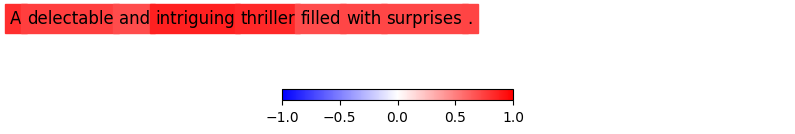

In [9]:
fig, _ = visualization.highlight_text(explanation_relevances, model_runner.tokenizer.tokenize(review))

All words seem relevant to the review's classification outcome. From the numerical values above, it is confirmed that all words contribute positively according to RISE, with "intriguing" as the most important word with the highest positive relevance score.

#### Trying more text explanations

And what are the words' relevancies to a '**negative**' classification decision?

In [10]:
explanation_relevances =  dianna.explain_text(model_runner, review, model_runner.tokenizer, 'RISE',
                                              labels=[labels.index('negative')])[0]
explanation_relevances

Explaining:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ChristiaanMeijer\AppData\Local\Temp\ipykernel_8180\1740688838.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))
Explaining: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Rise parameter p_keep was automatically determined at 0.2


Explaining: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


[('A', 0, 0.2629852992296219),
 ('delectable', 1, 0.12482632398605346),
 ('and', 2, 0.27418449968099595),
 ('intriguing', 3, 0.020306116938591003),
 ('thriller', 4, 0.17994431644678113),
 ('filled', 5, 0.32208009347319605),
 ('with', 6, 0.2551098448038101),
 ('surprises', 7, 0.32068729370832444),
 ('.', 8, 0.2672424094378948)]

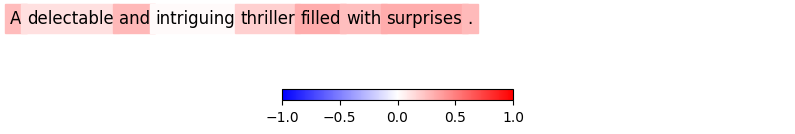

In [11]:
fig, _ = visualization.highlight_text(explanation_relevances, model_runner.tokenizer.tokenize(review))

Interestingly, RISE still gives positive, though smaller, relevance scores.

Let's try RISE on a negative review.

In [12]:
review = "What an auwful movie!"

In [13]:
explanation_relevances =  dianna.explain_text(model_runner, review, model_runner.tokenizer, 'RISE',
                                              labels=[labels.index('positive')])[0]
explanation_relevances

Explaining:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ChristiaanMeijer\AppData\Local\Temp\ipykernel_8180\1740688838.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))
Explaining: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


[('What', 0, 0.5652854725718498),
 ('an', 1, 0.5436604416966438),
 ('auwful', 2, 0.5264478924870492),
 ('movie', 3, 0.4800699933767319),
 ('!', 4, 0.5347845470905304)]

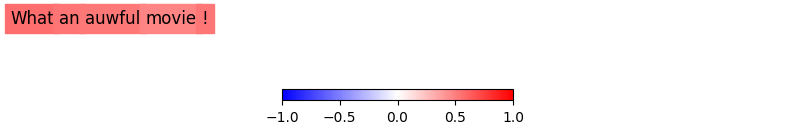

In [14]:
fig, _ = visualization.highlight_text(explanation_relevances, model_runner.tokenizer.tokenize(review))

In [15]:
explanation_relevances =  dianna.explain_text(model_runner, review, model_runner.tokenizer, 'RISE',
                                              labels=[labels.index('negative')])[0]
explanation_relevances

Explaining:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ChristiaanMeijer\AppData\Local\Temp\ipykernel_8180\1740688838.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))
Explaining: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Rise parameter p_keep was automatically determined at 0.5


Explaining: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[('What', 0, 0.4364011679291725),
 ('an', 1, 0.4379050084352493),
 ('auwful', 2, 0.45589199286699295),
 ('movie', 3, 0.5256366093754768),
 ('!', 4, 0.47428932881355285)]

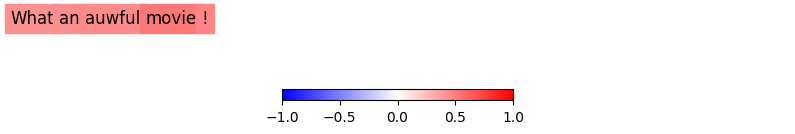

In [16]:
fig, _ = visualization.highlight_text(explanation_relevances, model_runner.tokenizer.tokenize(review))

And what about a harder to classify review with mixed words, but still a clear **'negative'** sentiment?

In [17]:
mixed_review = 'The movie started great but the ending is boring and unoriginal!'

In [ ]:
explanation_relevances =  dianna.explain_text(model_runner, mixed_review, model_runner.tokenizer, 'RISE',
                                              labels=[labels.index('negative')])[0]
explanation_relevances

Explaining:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\ChristiaanMeijer\AppData\Local\Temp\ipykernel_8180\1740688838.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(sigmoid(self.run_model([tokens_numerical])))
Explaining:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

In [ ]:
fig, _ = visualization.highlight_text(explanation_relevances, model_runner.tokenizer.tokenize(mixed_review))

All words contribute strongly to the 'negative' class, the least- the most positive word "great". 

What is the explanation if we question the model for its **'positive'** classification?

In [20]:
explanation_relevances =  dianna.explain_text(model_runner, mixed_review, model_runner.tokenizer, 'RISE',
                                              labels=[labels.index('positive')])[0]
explanation_relevances

Explaining: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


Rise parameter p_keep was automatically determined at 0.4


Explaining: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[('The', 0, 0.3930132823437452),
 ('movie', 1, 0.391335634062998),
 ('started', 2, 0.3736873556789942),
 ('great', 3, 0.5640122865419834),
 ('but', 4, 0.33719351702369743),
 ('the', 5, 0.394796144478023),
 ('ending', 6, 0.29160672857658937),
 ('is', 7, 0.34797732688020916),
 ('boring', 8, 0.1030324523244053),
 ('and', 9, 0.33656416439451275),
 ('unoriginal', 10, 0.26281975384335965),
 ('!', 11, 0.3825041185086593)]

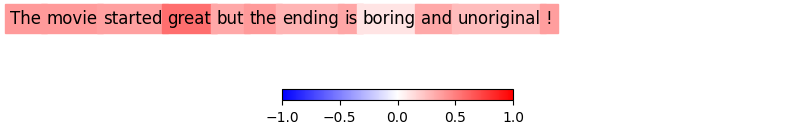

In [21]:
fig, _ = visualization.highlight_text(explanation_relevances, model_runner.tokenizer.tokenize(mixed_review))